# Different aspects of a complex call center model

## Importing modules

In [1]:
# Data collection
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.ticker as formater
import seaborn as sns

# Simulation
from queuesim import SimProcess, run_parallel
from queuesim.models import impatience_and_retry_model_build

# Analytic calcution
from queuesim.analytic import erlang_c_table, erlang_c_ext_table

# Defining general plot style
sns.set()
percent_formater = formater.PercentFormatter(xmax=1, decimals=0)

In [2]:
# Optional: Interactive diagram mode
# Run "pip install ipympl" first
# %matplotlib ipympl

## Impatience of the callers

### Model parameters

In [3]:
# Mean inter-arrival time
mean_i = 100

# Mean service time
mean_s_range = range(60, 121, 2)

# Mean waiting time tolerance range
mean_wt = 300

# Number of operators
c = 1

# Number of arrivals to be simulated
count = 100_000

### Simulation

In [4]:
models, simulators = run_parallel([SimProcess(impatience_and_retry_model_build(mean_i, mean_s, mean_wt, 0, 1, c, count)) for mean_s in mean_s_range])

31 parallel processes started.
All processes terminated, runtime: 14.1 seconds.
Results have been collected.


### Processing results

In [5]:
mu = [1 / model['meanS'] for model in models]
rho_offered = [model['meanS'] / model['meanI'] / model['c'] for model in models]
ENQ = [model['Process'].statistic_queue_length.mean for model in models]
EN = [model['Process'].statistic_wip.mean for model in models]
EW = [model['Dispose'].statistic_client_waiting.mean for model in models]
EV = [model['Dispose'].statistic_client_residence.mean for model in models]
PA = [1 - model['Process'].statistic_success.data['Success'] / model['Process'].statistic_success.count for model in models]

results = pd.DataFrame({'mu': mu, 'rho_offered': rho_offered, 'E[N_Q]': ENQ, 'E[N]': EN, 'E[W]': EW, 'E[V]': EV, 'P(A)': PA})

results

,mu,rho_offered,E[N_Q],E[N],E[W],E[V],P(A)
0,0.016667,0.60,0.423288,0.946275,37.630971,89.980161,0.12601
1,0.016129,0.62,0.451973,0.988567,40.108892,93.936405,0.13432
2,0.015625,0.64,0.475080,1.024035,42.063804,97.034783,0.14015
3,0.015152,0.66,0.511029,1.073863,45.193057,101.511826,0.15017
4,0.014706,0.68,0.534173,1.104586,47.122292,104.267309,0.15770
5,0.014286,0.70,0.563029,1.150193,49.455557,108.022726,0.16445
6,0.013889,0.72,0.588378,1.184299,51.466744,110.978030,0.17378
7,0.013514,0.74,0.623258,1.232257,54.446065,115.306777,0.18244
8,0.013158,0.76,0.651820,1.269423,56.940546,118.503411,0.18893
9,0.012821,0.78,0.675302,1.301471,58.969032,121.553660,0.19567


### Calculating Erlang C formula results

In [6]:
erlang_c_results = erlang_c_table([(1 / mean_i, mu, c) for mu in results[results["rho_offered"] < 1]["mu"]])
erlang_c_ext_results = erlang_c_ext_table([(1 / mean_i, mu, 1 / mean_wt, c, c * 100) for mu in results["mu"]])

### Plotting results

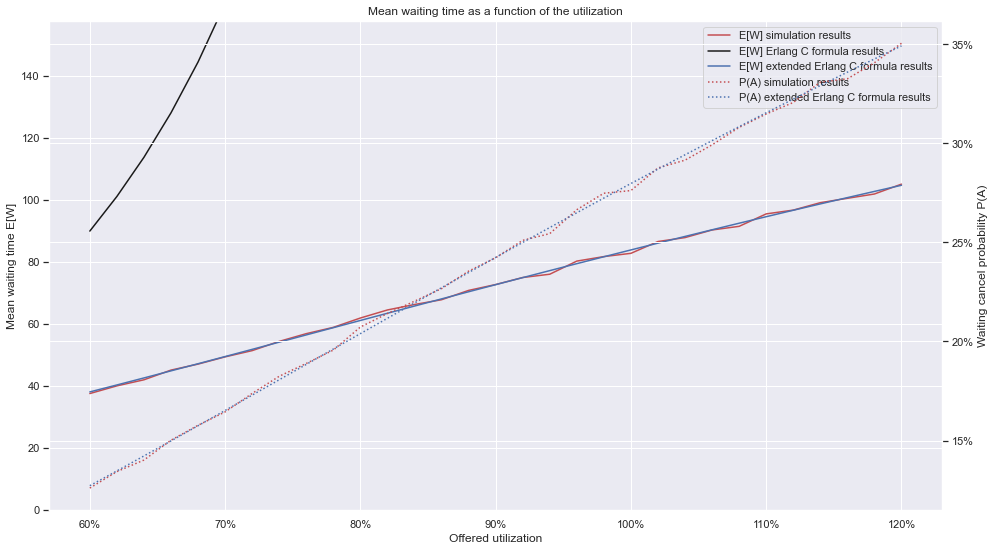

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(results['rho_offered'], results['E[W]'], 'r', label="E[W] simulation results")
ax.plot(erlang_c_results['rho'], erlang_c_results['E[W]'], 'k', label="E[W] Erlang C formula results")
ax.plot(erlang_c_ext_results['rho_offered'], erlang_c_ext_results['E[W]'], 'b', label="E[W] extended Erlang C formula results")
ax.xaxis.set_major_formatter(percent_formater)
ax.set_ylim([0, max(results['E[W]'] * 1.5)])
ax.set_xlabel("Offered utilization")
ax.set_ylabel("Mean waiting time E[W]")
lines1, labels1 = ax.get_legend_handles_labels()

ax2 = ax.twinx()
ax2.plot(results['rho_offered'], results['P(A)'], 'r:', label="P(A) simulation results")
ax2.plot(erlang_c_ext_results['rho_offered'], erlang_c_ext_results['P(A)'], 'b:', label="P(A) extended Erlang C formula results")
ax2.yaxis.set_major_formatter(percent_formater)
ax2.set_ylabel("Waiting cancel probability P(A)")
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_title("Mean waiting time as a function of the utilization")
ax.legend(lines1 + lines2, labels1 + labels2)

Calculating E[W] using the simple Erlang C formula (not respecting the impatience) gives completely wrong results. So the effect of impatience cannot be ignored. The extended Erlang C formula and the simulation results have a good match. We see the waiting time cancelation probability P(A) is increasing at an increasing offered utilization. The mean waiting time E[W] is also increasing but not in the same magnitude as it would without impatience. If there are waiting time cancelations, the system can also be operated with an offered utilization of more than 100%.

## Retry

### Model parameters

In [8]:
# Mean inter-arrival time
mean_i = 100

# Mean service time
mean_s_range = range(60, 121, 2)

# Mean waiting time tolerance range
mean_wt = 300

# Retry
retry_probability = 0.2
mean_retry_delay = 600

# Number of operators
c = 1

# Number of arrivals to be simulated
count = 100_000


### Simulation

In [9]:
models, simulators = run_parallel([SimProcess(impatience_and_retry_model_build(mean_i, mean_s, mean_wt, retry_probability, mean_retry_delay, c, count)) for mean_s in mean_s_range])

31 parallel processes started.
All processes terminated, runtime: 14.6 seconds.
Results have been collected.


### Processing results

In [10]:
mu = [1 / model['meanS'] for model in models]
rho_offered = [model['meanS'] / model['meanI'] / model['c'] for model in models]
ENQ = [model['Process'].statistic_queue_length.mean for model in models]
EN = [model['Process'].statistic_wip.mean for model in models]
EW = [model['Dispose'].statistic_client_waiting.mean for model in models]
EV = [model['Dispose'].statistic_client_residence.mean for model in models]
PA = [1 - model['Process'].statistic_success.data['Success'] / model['Process'].statistic_success.count for model in models]

results = pd.DataFrame({'mu': mu, 'rho_offered': rho_offered, 'E[N_Q]': ENQ, 'E[N]': EN, 'E[W]': EW, 'E[V]': EV, 'P(A)': PA})

results

,mu,rho_offered,E[N_Q],E[N],E[W],E[V],P(A)
0,0.016667,0.60,0.455341,0.989341,40.656135,94.098880,0.130999
1,0.016129,0.62,0.484719,1.033510,43.041862,97.924750,0.141164
2,0.015625,0.64,0.522241,1.085568,46.482206,102.952988,0.149050
3,0.015152,0.66,0.547873,1.122466,48.401080,105.893206,0.156612
4,0.014706,0.68,0.587308,1.175502,51.841272,110.549236,0.166306
5,0.014286,0.70,0.602084,1.195931,53.219215,112.636081,0.172119
6,0.013889,0.72,0.643982,1.258216,56.807677,118.238001,0.181567
7,0.013514,0.74,0.684741,1.311127,60.156153,122.537696,0.190337
8,0.013158,0.76,0.701266,1.335262,61.474424,124.799052,0.197656
9,0.012821,0.78,0.744884,1.390951,65.272786,129.849867,0.208930


### Calculating Erlang C formula results

In [11]:
erlang_c_ext_results = erlang_c_ext_table([(1 / mean_i, mu, 1 / mean_wt, c, c * 100) for mu in results["mu"]])

Using the simple Erlang C formula was already in the model above no good idea anymore. So when adding also retry, we have left of the simple Erlang C formula here. The extended Erlang C formula can handle impatience but no retry. So deviations between the simulation and the formula results can be expected.

### Plotting results

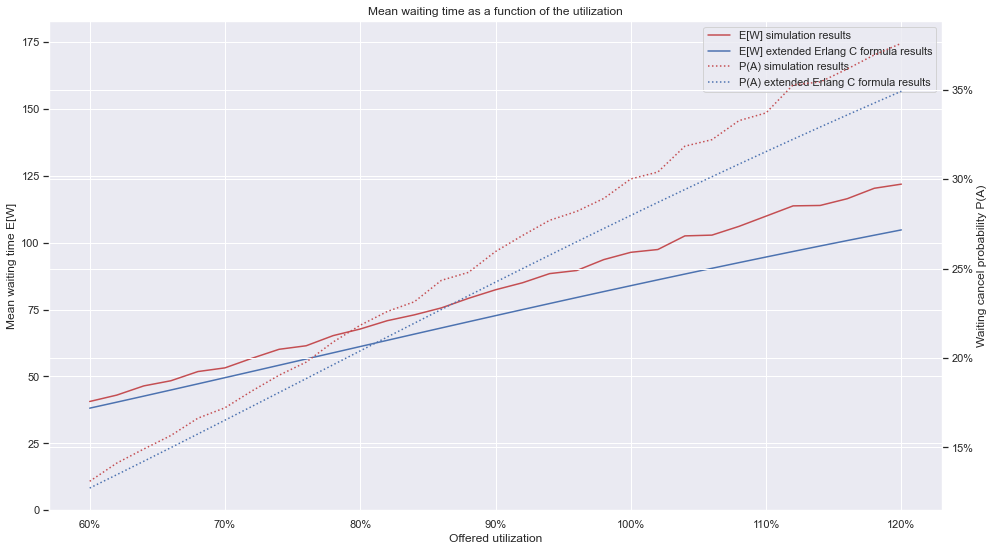

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(results['rho_offered'], results['E[W]'], 'r', label="E[W] simulation results")
ax.plot(erlang_c_ext_results['rho_offered'], erlang_c_ext_results['E[W]'], 'b', label="E[W] extended Erlang C formula results")
ax.xaxis.set_major_formatter(percent_formater)
ax.set_ylim([0, max(results['E[W]'] * 1.5)])
ax.set_xlabel("Offered utilization")
ax.set_ylabel("Mean waiting time E[W]")
lines1, labels1 = ax.get_legend_handles_labels()

ax2 = ax.twinx()
ax2.plot(results['rho_offered'], results['P(A)'], 'r:', label="P(A) simulation results")
ax2.plot(erlang_c_ext_results['rho_offered'], erlang_c_ext_results['P(A)'], 'b:', label="P(A) extended Erlang C formula results")
ax2.yaxis.set_major_formatter(percent_formater)
ax2.set_ylabel("Waiting cancel probability P(A)")
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_title("Mean waiting time as a function of the utilization")
ax.legend(lines1 + lines2, labels1 + labels2)

Only 20% of the callers who have canceled waiting are staring a new call attempt later. This increasaes the average waiting times as can be seen significantly compared to the results of the extended Erlang C formula (which does not map retry).